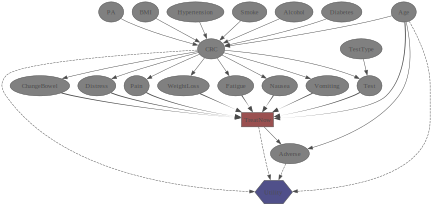

Posterior P(Adverse: 
  Adverse          |
No       |Yes      |
---------|---------|
 1.0000  | 0.0000  |

Optimal decision: 
                                                              ||  TreatNow         |
Age   |Test  |Vomiti|Nausea|Fatigu|Weight|Pain  |Distre|Change||No       |Yes      |
------|------|------|------|------|------|------|------|------||---------|---------|
30-59 |Negati|No    |No    |No    |No    |No    |No    |No    || 1.0000  | 0.0000  |
60-69 |Negati|No    |No    |No    |No    |No    |No    |No    || 1.0000  | 0.0000  |
70-79 |Negati|No    |No    |No    |No    |No    |No    |No    || 1.0000  | 0.0000  |
80+   |Negati|No    |No    |No    |No    |No    |No    |No    || 1.0000  | 0.0000  |
30-59 |Positi|No    |No    |No    |No    |No    |No    |No    || 1.0000  | 0.0000  |
60-69 |Positi|No    |No    |No    |No    |No    |No    |No    || 1.0000  | 0.0000  |
[...1012 more line(s) ...]
70-79 |Negati|Yes   |Yes   |Yes   |Yes   |Yes   |Yes   |Yes   || 1.0000  | 0.0000 

In [ ]:

import pyagrum as gum
import pyagrum.lib.notebook as gnb
import math
from itertools import product

#helper functions
def logit(p): return math.log(p/(1-p))
def inv_logit(x): return 1/(1+math.exp(-x))

#adjusting beta0 so that the models overall average predicted  probability matches the target prevelance (0.07).
# we know the RR for the risk factors, e.g. B1X1; B2X2
def calibrate_intercept(beta_base, parents_marginals, rr_params,
                        target_prev=0.0007, max_iter=200, tol=1e-10):
    beta0 = logit(target_prev) + beta_base
    for _ in range(max_iter):
        combos = [(0.0, 1.0)] # linear sum = 0 and probability = 1
        # go risk by risk and get log risk effect (B), vals is the list of (x_values and probabilities)
        for name, vals in parents_marginals.items():
            beta = rr_params.get(name, 0.0)
            new = [] #hold the expanded combinations after including this variable
            
            #lin = current predictor (sum of BxXx's so far) and pr = (combined probability of that combo so far)
            #for each combo so far we add the variables contribution to the linear predictor and multiply the probabilities
            for (lin, pr) in combos:
                for (xv, pv) in vals:
                    new.append((lin + beta*xv, pr*pv))
            combos = new
            # compute the predicted overall prevalence under the curren B0
        p_hat = sum(pr * inv_logit(beta0 + lin) for (lin, pr) in combos)
        #Check difference from the target
        diff = target_prev - p_hat
        if abs(diff) < tol: break
        #Adjust B0
        beta0 += diff / (p_hat*(1-p_hat) + 1e-12)
    return beta0

idg = gum.InfluenceDiagram()

# Cancer Node
crc = gum.LabelizedVariable("CRC","Colorectal Cancer",2) 
crc.changeLabel(0,"No"); crc.changeLabel(1,"Yes")
id_crc = idg.addChanceNode(crc)

# Risk factors
diab = gum.LabelizedVariable("Diabetes","Diabetes",2)
diab.changeLabel(0,"No"); diab.changeLabel(1,"Yes")
id_diabetes = idg.addChanceNode(diab)

pa   = gum.LabelizedVariable("PA","Physical Activity",2)
pa.changeLabel(0,"Low"); pa.changeLabel(1,"High")
id_physActivity = idg.addChanceNode(pa)

bmi  = gum.LabelizedVariable("BMI","BMI class",4)
for i,l in enumerate(["Under","Normal","Over","Obese"]): bmi.changeLabel(i,l)
id_bmi = idg.addChanceNode(bmi)

age = gum.LabelizedVariable("Age","Age band",4)
for i,l in enumerate(["30-59","60-69","70-79","80+"]): age.changeLabel(i,l)
id_age = idg.addChanceNode(age)

htn = gum.LabelizedVariable("Hypertension","Hypertension",2)
htn.changeLabel(0,"No"); htn.changeLabel(1,"Yes")
id_hypTension = idg.addChanceNode(htn)

smk = gum.LabelizedVariable("Smoke","Smoking status",3)
for i,l in enumerate(["Never","Former","Current"]): smk.changeLabel(i,l)
id_smoking = idg.addChanceNode(smk)

alc = gum.LabelizedVariable("Alcohol","Alcohol intake",2)
alc.changeLabel(0,"Low"); alc.changeLabel(1,"High")
id_alcohol = idg.addChanceNode(alc)

# Test Type & Result
tt = gum.LabelizedVariable("TestType","Test Type",3)
for i,l in enumerate(["FIT","FOBT","Colonoscopy"]): tt.changeLabel(i,l)
id_testType = idg.addChanceNode(tt)

test = gum.LabelizedVariable("Test","Diagnostic Test Result",2)
test.changeLabel(0,"Negative"); test.changeLabel(1,"Positive")
id_testResult = idg.addChanceNode(test)

# Symptoms of crc
sym_names = ["ChangeBowel","Distress","Pain","WeightLoss","Fatigue","Nausea","Vomiting"]
sym_ids = {"ChangeBowel": None, "Distress": None, "Pain": None, "Weightloss": None, "Fatigue": None, "Nausea": None, "Vomiting": None}
for s in sym_names:
    v = gum.LabelizedVariable(s,s,2); v.changeLabel(0,"No"); v.changeLabel(1,"Yes")
    sym_ids[s] = idg.addChanceNode(v)
    
# Adverse events of treatment
adv = gum.LabelizedVariable("Adverse","Treatment Adverse Event",2)
adv.changeLabel(0,"No"); adv.changeLabel(1,"Yes")
id_advTreat = idg.addChanceNode(adv)

# Decision node
treat = gum.LabelizedVariable("TreatNow","Decision: Initiate Treatment?",2)
treat.changeLabel(0,"No"); treat.changeLabel(1,"Yes")
id_treat = idg.addDecisionNode(treat)

# Utility 
U = gum.LabelizedVariable("Utility","Utility",1)
idg.addUtilityNode(U)

#  CPT for CRC given parent risk factors
for p in ["Diabetes","PA","BMI","Age","Hypertension","Smoke","Alcohol"]: #parent variables of CRC
    idg.addArc(p,"CRC")

for s in sym_names: idg.addArc("CRC",s) #arc from CRC to each symptom
idg.addArc("CRC","Test") 
idg.addArc("TestType","Test") 

for s in sym_names: idg.addArc(s,"TreatNow") #symptoms affect decision to treat now 
idg.addArc("Test","TreatNow")
idg.addArc("Age","TreatNow") 

idg.addArc("TreatNow","Adverse")
idg.addArc("Age","Adverse") 

for p in ["CRC","TreatNow","Adverse","Age"]:
    idg.addArc(p,"Utility")


#Root priors (from Corrales + age hybrid) 
idg.cpt("Diabetes").fillWith([0.9637,0.0363])                 # No, Yes 
idg.cpt("PA").fillWith([0.4721,0.5279])                       # Low , High
idg.cpt("BMI").fillWith([0.0110,0.4127,0.4067,0.1696])        # Under, Normal, Over, Obese

#age prior (Corrales + Hamilton incidence split)
idg.cpt("Age").fillWith([0.84693, 0.02944, 0.05495, 0.06869]) # 30-59, 60-69, 70-79, 80+ 

idg.cpt("Hypertension").fillWith([0.8495,0.1505])             # No, Yes
idg.cpt("Smoke").fillWith([0.4990,0.3016,0.1994])             # Never, Former, Current
idg.cpt("Alcohol").fillWith([0.9505,0.0495])                  # Low, High

# TestType prior 
idg.cpt("TestType").fillWith([1/3,1/3,1/3])                   # FIT, FOBT, Colonoscopy

#CRC | parents via logistic (RR-encoded)
# Diabetes RR ~1.31
beta_diab = math.log(1.31)                                   

# Low PA protective RR ~0.75
beta_lowPA = math.log(0.75)                                  

# BMI: per +5 kg/m^2 midpoint (1.165)
beta_per5 = math.log((1.24+1.09)/2.0)
bmi_steps = {"Under":-1, "Normal":0, "Over":1, "Obese":2}     

# Age: RRs vs 30-59 from Hamilton (male+female combined incidences)
age_RR = {"30-59":1.00, "60-69":6.5217, "70-79":12.1739, "80+":15.2174}
# logit(p) = B0 + Beta_age x age_x ...
age_x  = {k: math.log(v) for k,v in age_RR.items()} #loops over each key value pair in the dictionary above and computes the natural logarithm of the RR and stores it in a new dictionary with the sam ekey as above
beta_age = 1.0

# Hypertension RR ~1.15
beta_htn = math.log(1.15)

# Smoking RRs vs Never (Botteri 2020 paragraph on smoking and CRC)
smoke_RR = {"Never":1.00, "Former":1.17, "Current":1.14}
smoke_x  = {k: math.log(v) for k,v in smoke_RR.items()} 
beta_smoke = 1.0 

# Alcohol High vs Low RR ~1.50
beta_alc = math.log(1.50)

# Intercept calibration to target marginal P(CRC)=0.0007
parents_marginals = {
    "Diabetes":[(0,0.9637),(1,0.0363)],
    "PA":[(1,0.4721),(0,0.5279)],  # x=1 if Low
    "BMI":[(bmi_steps["Under"],0.0110),(0,0.4127),(1,0.4067),(2,0.1696)],
    "Age":[(age_x["30-59"],0.84693),(age_x["60-69"],0.02944),
           (age_x["70-79"],0.05495),(age_x["80+"],0.06869)],
    "Hypertension":[(0,0.8495),(1,0.1505)],
    "Smoke":[(smoke_x["Never"],0.4990),(smoke_x["Former"],0.3016),(smoke_x["Current"],0.1994)],
    "Alcohol":[(0,0.9505),(1,0.0495)],
}
rr_params = {
    "Diabetes":beta_diab,
    "PA":beta_lowPA,
    "BMI":beta_per5,
    "Age":beta_age,
    "Hypertension":beta_htn,
    "Smoke":beta_smoke,
    "Alcohol":beta_alc
}
beta0 = calibrate_intercept(0.0, parents_marginals, rr_params, target_prev=0.0007)

parents = ["Diabetes","PA","BMI","Age","Hypertension","Smoke","Alcohol"]
parent_states = {
    "Diabetes":["No","Yes"],
    "PA":["Low","High"],
    "BMI":["Under","Normal","Over","Obese"],
    "Age":["30-59","60-69","70-79","80+"],
    "Hypertension":["No","Yes"],
    "Smoke":["Never","Former","Current"],
    "Alcohol":["Low","High"]
}
def x_value(name, label):
    if name=="Diabetes":      return 1 if label=="Yes" else 0
    if name=="PA":            return 1 if label=="Low" else 0
    if name=="BMI":           return bmi_steps[label]
    if name=="Age":           return age_x[label]
    if name=="Hypertension":  return 1 if label=="Yes" else 0
    if name=="Smoke":         return smoke_x[label]
    if name=="Alcohol":       return 1 if label=="High" else 0
    return 0

cpt_crc = gum.Tensor() #create the empty table
for p in parents: cpt_crc.add(idg.variable(p)) #add all the parent variables as dimensions
cpt_crc.add(idg.variable("CRC")) #add CRC as the child

from itertools import product
#combo is one combination of parent states 
for combo in product(*[parent_states[p] for p in parents]):
    labels = dict(zip(parents, combo))
    #compute linear predictor: lin = B0 + sum (B1X1 + ...)
    lin = beta0 + sum(rr_params[p]*x_value(p, labels[p]) for p in parents)
    #compute the probability using the helper function
    p1 = inv_logit(lin)
    idx = {p: parent_states[p].index(labels[p]) for p in parents}
 
    cpt_crc[{**idx,"CRC":0}] = 1 - p1    #sets probability CRC = No
    cpt_crc[{**idx,"CRC":1}] = p1
idg.cpt(id_crc).fillWith(cpt_crc)

# Symptoms CPTs 
p_sym_crc = {"ChangeBowel":87.6,"Distress":75.8,"Pain":73.9,
             "WeightLoss":62.1,"Fatigue":56.7,"Nausea":33.9,"Vomiting":26.7}
p_sym_not = {"ChangeBowel":8.6,"Distress":12.1,"Pain":14.0,
             "WeightLoss":7.3,"Fatigue":18.5,"Nausea":5.2,"Vomiting":3.1}
#build the probability tables for each symptom given CRC (Given whether a person has CRC, what's the probability they will show this symptom)
for s in sym_names:
    p1 = p_sym_crc[s]/100.0 #percentage of people with CRC who have this symptoms
    q1 = p_sym_not[s]/100.0 #percentage of people without CRC who have this symptom
    pot = gum.Tensor().add(idg.variable("CRC")).add(idg.variable(s)) # P(Sym,CRC)
    pot[{"CRC":0,s:0}] = 1-q1; pot[{"CRC":0,s:1}] = q1
    pot[{"CRC":1,s:0}] = 1-p1; pot[{"CRC":1,s:1}] = p1
    idg.cpt(sym_ids[s]).fillWith(pot)

#TestType + Test CPTs

#sensitivity and specificity for:
# - FIT --> "Optimal Strategies for Colorectal Cancer Screening-Shailavi Jain"
# - FOB --> "Optimal Strategies for Colorectal Cancer Screening-Shailavi Jain" (range given, median used)
# - Colonoscopy --> ""Optimal Strategies for Colorectal Cancer Screening-Shailavi Jain" (range given, median used)"
sens = {"FIT":0.74,"FOBT":0.50,"Colonoscopy":0.92}
spec = {"FIT":0.94, "FOBT":0.625,"Colonoscopy":0.89}

####       P(Test/CRC,TestType)  -> how likely is it that the test result will be positive or negative
pot_test = gum.Tensor().add(idg.variable("CRC")).add(idg.variable("TestType")).add(idg.variable("Test"))
for i_crc, clab in enumerate(["No","Yes"]):
    for i_tt, ttype in enumerate(["FIT","FOBT","Colonoscopy"]):
        Se = sens[ttype]; Sp = spec[ttype]
        #compute the probability of a positive test
        p_pos = Se if clab=="Yes" else (1 - Sp) # use sensitivity if true positive else use 1-specificity if false positive
        pot_test[{"CRC":i_crc,"TestType":i_tt,"Test":0}] = 1 - p_pos
        pot_test[{"CRC":i_crc,"TestType":i_tt,"Test":1}] = p_pos
idg.cpt(id_testResult).fillWith(pot_test)

# Adverse events after treatment 
# Resulting union probabilities:
#   <50:    0.2503
#   50-65:  0.1884
#   >65:    0.2550   

# Map to bins:
#  - 30-59: ≈ (2/3)*0.2503 + (1/3)*0.1884 = 0.23
#  - 60-69: ≈ 0.5*(0.1884 + 0.2550)       = 0.2217
#  - 70-79: 0.2550
#  - 80+:   0.2550

p_adv_map = {
    "30-59": 0.23,
    "60-69": 0.2217,
    "70-79": 0.2550,
    "80+": 0.2550,
}
# P(Adverse|TreatNow,Age)

pot_adv = gum.Tensor().add(idg.variable("TreatNow")).add(idg.variable("Age")).add(idg.variable("Adverse"))
for i_t, tlab in enumerate(["No","Yes"]):
    for i_a, alab in enumerate(["30-59","60-69","70-79","80+"]):
        #set probability of adverse event based on treatment and age
        if tlab == "Yes":
            p_adv = p_adv_map[alab]
        else:
            # If treatement not given, no adverse events
            p_adv = 0.0
        pot_adv[{"TreatNow": i_t, "Age": i_a, "Adverse": 1}] = p_adv
        pot_adv[{"TreatNow": i_t, "Age": i_a, "Adverse": 0}] = 1.0 - p_adv #probability of no adverse event

idg.cpt(id_advTreat).fillWith(pot_adv)

# Utility

id_utility = idg.idFromName("Utility")

# Define the age category and base scores
ages = ["30-59", "60-69", "70-79", "80+"]
age_base = {"30-59": 100, "60-69": 95, "70-79": 90, "80+": 85}

pen_crc_untreated = -60   # penalty if CRC present & not treated
treat_gain_on_crc = +50   # benefit recovered when treating CRC
pen_ae_if_treated = -20   # penalty for major AE (only if treated)
pen_overtreat = -50       # penalty for treating when CRC is absent

# Function to compute scaled score
def scaled_score(age, crc, treat, ae):
    score = age_base[age]
    if crc == "Yes":
        if treat=="No":
            score += pen_crc_untreated
        else:
            score += treat_gain_on_crc
    else:
        if treat == "Yes":
            score += pen_overtreat
    if treat == "Yes" and ae == "Yes":
        score += pen_ae_if_treated
    score = max(0, min(100, score))
    return score / 100.0

# Create the utility potential table
uPot = (
    gum.Tensor() 
    .add(idg.variable("CRC"))
    .add(idg.variable("TreatNow"))
    .add(idg.variable("Adverse"))
    .add(idg.variable("Age"))
    .add(idg.variable("Utility")) 
)

# Add the utility values (scaled scores)
for i_crc, crc_lab in enumerate(["No", "Yes"]):
    for i_tr, tr_lab in enumerate(["No", "Yes"]):
        for i_ae, ae_lab in enumerate(["No", "Yes"]):
            for i_age, age_lab in enumerate(ages):
                u = scaled_score(age_lab, crc_lab, tr_lab, ae_lab)
                uPot[{
                    "CRC": i_crc,
                    "TreatNow": i_tr,
                    "Adverse": i_ae,
                    "Age": i_age,
                    "Utility": 0
                }] = u

idg.utility(id_utility).fillWith(uPot)
gnb.showInfluenceDiagram(idg)


# Patient profiles to be ysed as evidence
patient1 = {'Age': "30-59",'BMI':"Normal", 'PA':"High", 'Smoke':"Never", 'Alcohol':"Low", 'Diabetes':"No", 'Hypertension':"No", 'ChangeBowel':"No", 'Distress':"No", 'Pain':"No", 'WeightLoss':"No", 'Fatigue':"No", 'Nausea':"No", 'Vomiting':"No", 'TestType':"FIT", 'Test':"Negative", 'CRC':"No"}
patient2 = {'Age': "60-69",'BMI':"Over", 'PA':"Low", 'Smoke':"Former", 'Alcohol':"Low", 'Diabetes':"Yes", 'Hypertension':"Yes", 'ChangeBowel':"Yes", 'Distress':"No", 'Pain':"Yes", 'WeightLoss':"No", 'Fatigue':"Yes", 'Nausea':"No", 'Vomiting':"No", 'TestType':"FIT", 'Test':"Positive", 'CRC':"Yes"}
patient3 = {'Age': "70-79",'BMI':"Obese", 'PA':"Low", 'Smoke':"Current", 'Alcohol':"High", 'Diabetes':"Yes", 'Hypertension':"Yes", 'ChangeBowel':"Yes", 'Distress':"Yes", 'Pain':"Yes", 'WeightLoss':"Yes", 'Fatigue':"Yes", 'Nausea':"Yes", 'Vomiting':"No", 'TestType':"FIT", 'Test':"Positive", 'CRC':"Yes"}
patient4 = {'Age': "80+",'BMI':"Over", 'PA':"Low", 'Smoke':"Former", 'Alcohol':"Low", 'Diabetes':"No", 'Hypertension':"Yes", 'ChangeBowel':"Yes", 'Distress':"Yes", 'Pain':"Yes", 'WeightLoss':"Yes", 'Fatigue':"Yes", 'Nausea':"No", 'Vomiting':"No", 'TestType':"Colonoscopy", 'Test':"Positive", 'CRC':"Yes"}
patient5 = {'Age': "30-59",'BMI':"Normal", 'PA':"High", 'Smoke':"Never", 'Alcohol':"Low", 'Diabetes':"No", 'Hypertension':"No", 'ChangeBowel':"No", 'Distress':"No", 'Pain':"No", 'WeightLoss':"No", 'Fatigue':"No", 'Nausea':"No", 'Vomiting':"No", 'TestType':"FIT", 'Test':"Positive", 'CRC':"No"}
patient6 = {'Age': "60-69",'BMI':"Obese", 'PA':"Low", 'Smoke':"Current", 'Alcohol':"High", 'Diabetes':"Yes", 'Hypertension':"Yes", 'ChangeBowel':"Yes", 'Distress':"Yes", 'Pain':"Yes", 'WeightLoss':"Yes", 'Fatigue':"Yes", 'Nausea':"Yes", 'Vomiting':"Yes", 'TestType':"FOBT", 'Test':"Positive", 'CRC':"Yes"}
patient7 = {'Age': "70-79",'BMI':"Normal", 'PA':"Low", 'Smoke':"Former", 'Alcohol':"Low", 'Diabetes':"Yes", 'Hypertension':"No", 'ChangeBowel':"Yes", 'Distress':"No", 'Pain':"No", 'WeightLoss':"No", 'Fatigue':"Yes", 'Nausea':"No", 'Vomiting':"No", 'TestType':"FIT", 'Test':"Negative", 'CRC':"No"}
patient8 = {'Age': "80+",'BMI':"Obese", 'PA':"Low", 'Smoke':"Current", 'Alcohol':"High", 'Diabetes':"Yes", 'Hypertension':"Yes", 'ChangeBowel':"Yes", 'Distress':"Yes", 'Pain':"Yes", 'WeightLoss':"Yes", 'Fatigue':"Yes", 'Nausea':"Yes", 'Vomiting':"Yes", 'TestType':"FIT", 'Test':"Negative", 'CRC':"Yes"}
patient9 = {'Age': "60-69",'BMI':"Normal", 'PA':"High", 'Smoke':"Never", 'Alcohol':"Low", 'Diabetes':"No", 'Hypertension':"Yes", 'ChangeBowel':"Yes", 'Distress':"No", 'Pain':"Yes", 'WeightLoss':"Yes", 'Fatigue':"Yes", 'Nausea':"No", 'Vomiting':"No", 'TestType':"FIT", 'Test':"Positive", 'CRC':"No"}
patient10 = {'Age': "70-79",'BMI':"Over", 'PA':"Low", 'Smoke':"Current", 'Alcohol':"High", 'Diabetes':"Yes", 'Hypertension':"Yes", 'ChangeBowel':"Yes", 'Distress':"Yes", 'Pain':"Yes", 'WeightLoss':"Yes", 'Fatigue':"Yes", 'Nausea':"No", 'Vomiting':"No", 'TestType':"FOBT", 'Test':"Negative", 'CRC':"No"}
patient11= {'Age': "30-59",'BMI':"Normal", 'PA':"High", 'Smoke':"Never", 'Alcohol':"Low", 'Diabetes':"No", 'Hypertension':"No", 'ChangeBowel':"No", 'Distress':"No", 'Pain':"No", 'WeightLoss':"No", 'Fatigue':"No", 'Nausea':"No", 'Vomiting':"No", 'TestType':"Colonoscopy", 'Test':"Negative", 'CRC':"No"}
patient12 = {'Age': "80+",'BMI':"Over", 'PA':"Low", 'Smoke':"Former", 'Alcohol':"High", 'Diabetes':"Yes", 'Hypertension':"Yes", 'ChangeBowel':"Yes", 'Distress':"Yes", 'Pain':"Yes", 'WeightLoss':"Yes", 'Fatigue':"Yes", 'Nausea':"Yes", 'Vomiting':"Yes", 'TestType':"Colonoscopy", 'Test':"Positive", 'CRC':"Yes"}

ie = gum.ShaferShenoyLIMIDInference(idg)
ie.setEvidence(patient12)
ie.makeInference()

 
print("Posterior P(AdverseEvent):", ie.posterior("Adverse"))
#print("Optimal decision:", ie.optimalDecision("TreatNow"))
print("Posterior Utility:", ie.posteriorUtility("TreatNow"))

  